In [1]:
%matplotlib inline
from numpy import linalg as LA
import sys
from collections import defaultdict
import numpy as np
import pylab as plt
import matplotlib.cm as cm
import statsmodels.api as sm
from os import listdir
import json
import string
printable = set(string.printable)
from difflib import SequenceMatcher
import networkx as nx
import scipy
import statsmodels.api as sm
import itertools
import torch
import pandas as pd 

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % d)
    sys.stdout.flush()

### Load Skill List

Skill list format: one skill per line


In [2]:
dicpath="skills-list-MAIN-2010-2016.txt"
line=open(dicpath,"r",encoding = 'latin').read().splitlines()
skills=sorted([i.lower() for i in line])

### Load Open Syllabus Data

Format
column1 = year
Column2 = course id
column3 = Title
column4 = keywords

In [3]:
sf=dict((i,dict((y,0) for y in range(2010,2017))) for i in skills)
#for n in range(1000):
for n in range(1):  # sample size
   # flushPrint(n)
    with open(str(n)+'.txt','r', encoding = 'latin') as f:
        for line in f:
            line=line.strip().split('\t')
            year=int(line[0])
            idd=line[1]
            title=line[2]
            keys=line[3:]
            for j in keys:
                j=j.lower()
                if j in sf:
                    sf[j][year]+=1

Calculate skills frequency from open syllabus data and save it as skillFrequency.txt

In [4]:
data=sorted([[sum(v.values()),k] for k,v in sf.items()],reverse=True)
with open('skillFrequeny.txt', "w",encoding = 'latin') as f:
    for i,j in data:
        f.write(str(j)+'\t'+ str(i) + '\n')


Create a dictionary from Open syllabus data with year range

In [5]:
m=defaultdict(lambda:0)
#for n in range(1000):
for n in range(1): # sample size
   # flushPrint(n)
    with open(''+str(n)+'.txt','r', encoding = 'latin') as f:
        for line in f:
            line=line.strip().split('\t')
            year=int(line[0])
            m[year]+=1

In [6]:
E=defaultdict(lambda:0)
for n in range(1): # sample size
#for n in range(1000):
   # flushPrint(n)
    with open(''+str(n)+'.txt','r', encoding = 'latin') as f:
        for line in f:
            line=line.strip().split('\t')
            year=int(line[0])
            idd=line[1]
            title=line[2]
            keys=sorted(line[3:])
            for i,j in itertools.combinations(keys, 2):
                E[(i,j)]+=1

In [7]:
F=defaultdict(lambda:0)
for n in range(1): # sample size
#for n in range(1000):
   # flushPrint(n)
    with open(''+str(n)+'.txt','r', encoding = 'latin') as f:
        for line in f:
            line=line.strip().split('\t')
            year=int(line[0])
            idd=line[1]
            title=line[2]
            keys=sorted(line[3:])
            F[len(keys)]+=1

### Co-occurences

In [8]:
G=nx.Graph()
for k in E:
    i,j =k
    v=E[k]
    if v>=1000 and len(i)>=3 and len(j)>=3:
        G.add_edge(i,j)

In [11]:
F=[]
for k in E:
    i,j =k
    v=E[k]
    if v>=1000 and len(i)>=3 and len(j)>=3:
        F.append([i,j,v])
F=sorted(F)

In [12]:
with open('coocurCore.txt', "w", encoding = 'latin') as f:
    for i,j,v in F:
        f.write(i+'\t'+ j+'\t'+str(v) + '\n')

conversion from cartesian to polar coordinates

In [35]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return phi,rho
import torch as th

## Model
https://github.com/facebookresearch/poincare-embeddings
train coocurCore.txt using poincare-embeddings

#Uncomment and Run the following code
pt = th.load('coocurCore.pt')
pos=dict(zip(pt['objects'],pt['model']['lt.weight'].numpy()))
embedding = np.array(pos.values()).T
posP=dict((i,cart2pol(*pos[i])) for i in pos)
embeddingP = np.array(posP.values()).T
len(posP)

### Load skills clusters

Skill TAB SkillCluster TAB SkillFamily

In [26]:
df = pd.read_csv('skills-cluster-list.txt', sep='\t', header=0)

In [30]:
a = [i.encode('utf-8').strip() for i in df.Skill.tolist()]
b = [i.encode('utf-8').strip() for i in df.SkillCluster.tolist()]
c = [i.encode('utf-8').strip() for i in df.SkillFamily.tolist()]

In [37]:
dic=dict(zip([i.lower() for i in a],c))

In [32]:
from collections import Counter

l=list(zip(*sorted(Counter([dic[i] for i in posP if i in dic ]).items(),\
                 key=lambda x:-x[1])[0:2])[0])

In [252]:
ll=list(zip(*sorted(Counter([dic[i] for i in posP if i in dic ]).items(),\
                 key=lambda x:-x[1]))[0])

### Load skills frequency per year

      count count count
skill year1 year2 year3 ...

In [220]:
F={}
with open('yearlyOpenSy.txt', "r", encoding= 'latin') as f:
    for line in f:
        line=line.strip().split('\t')
        k=line[0]
        v=sum(map(int,line[1:]))
        F[k]=v


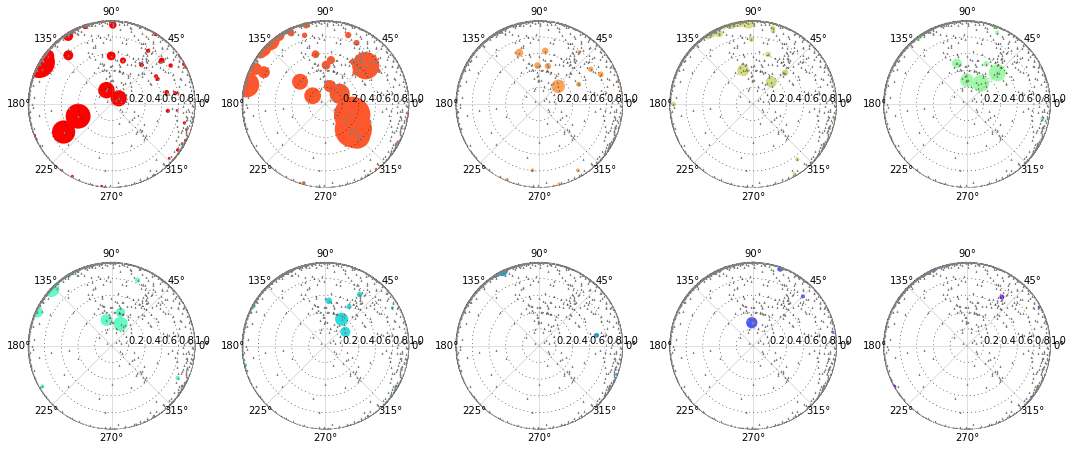

In [266]:
fig = plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('rainbow_r',10)
for n in range(10):
    ax = fig.add_subplot(2,5,n+1, projection='polar')
    l1=ll[n]
    ax.scatter(embeddingP[0], embeddingP[1],c='gray',
               s=5,linewidths=0,zorder=2,alpha=1,marker='^')  
    for i in posP:
        pi,r=posP[i]
        if i in dic and dic[i] == l1 and i in F:
            plt.scatter(pi,r,facecolor=cmap(n),s=F[i]/1000.0,edgecolor='')
    ax.spines['polar'].set_visible(False)
    ax.set_rmax(1)
    ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
    ax.set_rlabel_position(0)
    #plt.title(ll)
plt.tight_layout()

plt.show()

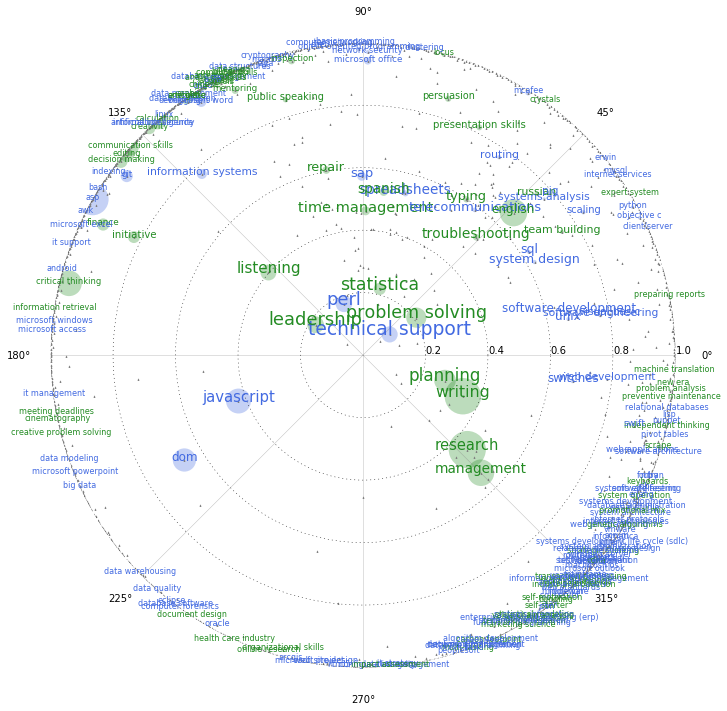

In [285]:
fig = plt.figure(figsize=(10, 10))
cmap = ['RoyalBlue','ForestGreen']
ax = fig.add_subplot(111, projection='polar')
ax.scatter(embeddingP[0], embeddingP[1],c='gray',
           s=5,linewidths=0,zorder=2,alpha=1,marker='^')    
for i in posP:
    pi,r=posP[i]
    if i in dic and dic[i] in l and i in F:
        cl=l.index(dic[i])
        plt.scatter(pi,r,facecolor=cmap[cl],s=F[i]/1000.0,edgecolor='',alpha=0.3)
        if F[i]/500.0>0:
            plt.text(pi,r,i,ha='center',color=cmap[cl],alpha=1,fontsize=(1-r)*12+8)
ax.set_rmax(1)
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.set_rlabel_position(0)

plt.tight_layout()
plt.show()